In [1]:
# imports
import numpy as np
import pandas as pd
import spglib
import scipy.io
import os

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
from matplotlib import cm
from skimage import measure

from ipywidgets import widgets
import ipywidgets
from IPython.display import display

from crystex import projections, plots, lattice, coordgeometry, rotations,\
                    fileutils, misorientations, symmetry
from crystex.lattice import crystal2ortho, reciprocal_lattice_vecs

from vecmaths import rotation
import vecmaths.vectors as vec_ops


## Functions

In [61]:
def plot_pole_fig_paper(proj_poles, poles,  lattice_sys=None, axes='xyz',
                  grid=False, clrs=None, title=None, pole_lbl=None,
                  marker_size=0.005, proj_poles_theory=None, clr_exp='#1b9e77'):
    """
    Return a figure object for a pole figure. For a single crystal, plots a single 
    pole figure for all `poles`. For a poly crystal, plots n pole figures, one 
    for each pole in `poles`. 

    Parameters
    ----------
    proj_poles : tuple of ndarrays of shape (n,)
        Arrays of `n` polar angles and radii as projections of poles.
    poles : ndarray of shape (3, n)
        Specify poles to be plotted as column vectors.
    lattice_sys : string, optional
        Lattice system is one of cubic, hexagonal, rhombohedral, tetragonal, 
        orthorhombic, monoclinic, triclinic.
    axes  : string
        Set alignment of sample axes with projection sphere axes. Options:
        'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'.
    grid : bool
        Turn grid lines on plot on or off (default).
    clrs : list of string
        A list of colours for theoretical poles.
    title: string
        Plot title
    proj_poles_theory : list of ndarrays of shape (2, n) or list of lists for multiple
        components
        Arrays of `n` polar angles and radii as projections of the theoretical poles.
    Returns
    -------
    f : matplotlib figure

    TODO:
    - Sort out plot labelling: based on lattice system for single crystal, and
        based on plotted pole for polycrystal.
    - Think about whether to have more than one pole figure for a single crystal 
    as well.
    - Add check the lenght of proj_poles = number of poles given.
    - Add label with plot details: phase, projection type, upper hemisphere, 
    data plotted.
    - Think about link between number of bins and angles.

    """
    # Check valid entry for axes alignment
    all_axes = ['xyz', 'yzx', 'zxy', 'yxz', 'zyx', 'xzy']
    if axes not in all_axes:
        raise ValueError('"{}" is not a valid axes option. '
                         '`axes` must be one of: {}.'.format(
                             axes, all_axes))


    n_figs = len(proj_poles)
    width_ratios = np.append([1] * n_figs, 0.1)
    # get poles labels
    poles_lbl = []
    for i in range(n_figs):
        poles_lbl.append(''.join([str(x) for x in poles[:, i]]))


    f_width = 3 * n_figs
    f_height = 10
    f = plt.figure(1, figsize=(f_width, f_height))
    gs0 = gridspec.GridSpec(1, 1)
    gs0.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)
    gs00 = gridspec.GridSpecFromSubplotSpec(1, n_figs+1, subplot_spec=gs0[0], width_ratios=width_ratios)
        
    m = ['o', 'x']
    
    # Plot scatter pole figures
    for n in range(n_figs):
        ax = f.add_subplot(gs00[n], projection='polar')
        
        cax = ax.scatter(proj_poles[n][0],
                            proj_poles[n][1],
                         c=clr_exp, 
                         s=marker_size, marker='o')

        if proj_poles_theory is not None and len(proj_poles_theory)==2:
            for p_i, proj_th in enumerate(proj_poles_theory):
                if p_i == 0:
                    cax = ax.scatter(proj_th[n][0],
                            proj_th[n][1], c=clrs[p_i], s=20, marker=m[p_i], )
                else:
                    cax = ax.scatter(proj_th[n][0],
                            proj_th[n][1], c=clrs[p_i], s=20, marker=m[p_i], # edgecolors
                                     linewidths=2)
        elif proj_poles_theory is not None:
            cax = ax.scatter(proj_poles_theory[n][0],
                        proj_poles_theory[n][1], cmap=cm.hsv,  marker='v')

        ax.set_rmax(1)
        ax.set_xticklabels(['', '', '', '', '', '', '', ''])
        
        ax.set_yticklabels([])
        if type(pole_lbl)==list:
            ax.set_title(pole_lbl[n], fontsize=14)  # loc='left'
        
        if not grid:
            ax.yaxis.grid(False)
            
        xgridlines = ax.xaxis.get_gridlines()
        [grl.set_alpha(0) for grl in xgridlines[1::2]]

    return f

# EBSD

This notebook presents code for exploring the EBSD and SPED orientation data for metal grain 2 and oxide region 2, and also for calculating the theoretical orientation relationships between the crystallographic phases.  

## Metal Zr

### Load experimental data

In [67]:
pole_type = 'plane-normal' # 'direction' / 'plane-normal'
proj_type='equal_area'  # 'stereographic' / 'equal-area' 
align='cz'          
hcp_sym_ops = symmetry.SYM_OPS['6/mmm']



In [68]:
# USER INPUT: Input file path-------------------------------------------------
home_path = './data/'
file_path = r'EBSD_metal_grain_2.ctf'
# ----------------------------------------------------------------------------

tw = widgets.ToggleButtons(
    description='Technique:',
    options=['ASTAR', 'EBSD'],
)
display(tw)

ToggleButtons(description='Technique:', options=('ASTAR', 'EBSD'), value='ASTAR')

In [69]:
# Read data
header = fileutils.read_ctf_header(os.path.join(home_path, file_path), )
n_ph = header['no_phases']

data = pd.read_csv(os.path.join(home_path, file_path), sep='\t', header=13 + n_ph).values

XCells = header['XCells']
YCells = header['YCells']
num_pix = XCells * YCells

idx_rows = np.tile(np.arange(XCells), YCells)
idx_cols = np.repeat(np.arange(YCells), XCells)

phases = data[:,0].astype(int)
phases -= 1
euler_angles = data[:,5:8]
mad = data[:,8]
bc = data[:,9]
bs = data[:,10]

phase_map = phases.reshape((XCells,YCells), order = 'F')

eul_map = euler_angles.reshape((XCells,YCells, 3), order = 'F')
eul_map_norm = np.copy(eul_map)
eul_map_norm[:,:,0] /= 360.0
eul_map_norm[:,:,1] /= 180.0
eul_map_norm[:,:,2] = coordgeometry.wrap_angles(eul_map_norm[:,:,2], 0.0, 360.0)
eul_map_norm[:,:,2] /= 360.0

mad_map = mad.reshape((XCells,YCells), order = 'F')
bc_map = bc.reshape((XCells,YCells), order = 'F')
bs_map = bs.reshape((XCells,YCells), order = 'F')

# Map options based on technique
map_opt = []
tech = tw.value # technique type
if tech == 'EBSD':
    map_opt.append('band contrast')
    map_opt.append('mean angular deviation')
    
else:
    map_opt.append('intensity')
    map_opt.append('reliability factor')
map_opt.append('phases')
map_opt.append('euler angles')

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [70]:
print('Total number of pixels: ', num_pix)
print(header['phases'][0]['name'], np.sum(phases == 0))
print(header['phases'][1]['name'], np.sum(phases == 1))
print(header['phases'][2]['name'], np.sum(phases == 2))
print('Non-indexed', np.sum(phases == -1))

Total number of pixels:  160000
Zirconia tetragonal 25
Zirc-alloy4 3335
Zr02 monoclinic 5
Non-indexed 156627


### Plot experimental pole figures

In [71]:
ph_opt = [x['name'] for x in header['phases']]
all_ph_ind = [index+1 for index, value in enumerate(ph_opt)]

style = {'description_width': 'initial'}
w = widgets.RadioButtons(
    description='Choose a phase',
    options=ph_opt,
    layout=ipywidgets.Layout(width='100%', height='80px'),
    style=style,
    index=1
)
display(w)

RadioButtons(description='Choose a phase', index=1, layout=Layout(height='80px', width='100%'), options=('Zirc…

In [72]:
# Phase index, name and lattice parameters
ph_ind = ph_opt.index(w.value)
ph_name = w.value
ph_params = header['phases'][ph_ind]['lattice_params']

# Create masks to be used for plotting the right data
mask_1d = phases != ph_ind
mask_2d = np.repeat(mask_1d[:,np.newaxis], 2, axis=1)
mask_3d = np.repeat(mask_1d[:,np.newaxis], 3, axis=1)

print('Chosen phase: ')
print(header['phases'][ph_ind])

Chosen phase: 
{'name': 'Zirc-alloy4', 'lattice_params': [3.231, 3.231, 5.148, 90.0, 90.0, 120.0]}


In [73]:
# USER INPUT: Pole figure options---------------------------------------------
lattice_system = 'hexagonal'
poles = np.array([[1,-1,0,0], [1,1,-2,0],[0,0,0,1], [1,0,-1,2]]).T
proj_type = 'equal_area'   # 'stereographic' or 'equal_area'
plot_contour = False        # True or False
axes = 'xyz'                #'zyx' 'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'
# ----------------------------------------------------------------------------


In [74]:
latt_params_hcp = ph_params  #a, b, c, α, β, γ

#------------------------------------------------------

params_dict_hcp = {
    'a': latt_params_hcp[0],
    'b': latt_params_hcp[1],
    'c': latt_params_hcp[2],
    'α': latt_params_hcp[3],
    'β': latt_params_hcp[4],
    'γ': latt_params_hcp[5]}
M_hcp = lattice.crystal2ortho(lattice_system, **params_dict_hcp, normed=False,
                                  degrees=True, align='cz')
cell_e = np.eye(3)
cell_ortho_hcp = np.dot(M_hcp.T, cell_e)
cell_rec_hcp = lattice.reciprocal_lattice_vecs(cell_ortho_hcp)

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



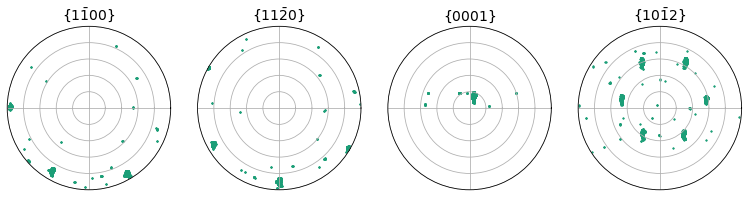

In [79]:
#  code
apply_rot = rotations.ax_ang2rot_mat(np.array([[0,0,1]]), 180, degrees=True)
eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0).astype('float64')

rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m.astype('float64'), degrees=True))


proj_poles = projections.project_crystal_poles(poles, 
                                               rot_mat=apply_rot@rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                               apply_sym=True)


pole_lbl = [r'{$1\bar{1}00$}', r'{$11\bar{2}0$}', r'{$0001$}', r'{$10\bar{1}2$}']


fig = plot_pole_fig_paper(proj_poles, poles=poles, 
                          pole_lbl=pole_lbl,
                          lattice_sys=lattice_system, axes=axes, 
                         marker_size=1, grid=True)
plt.show(fig)

### Calculate mean metal orientation

In [76]:
# inverse matrix needed
r_met =np.linalg.inv(rotations.euler2rot_mat_n(np.mean(eulers_m, axis=0)[None], degrees=True))
r_met_inv = np.linalg.inv(r_met)

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



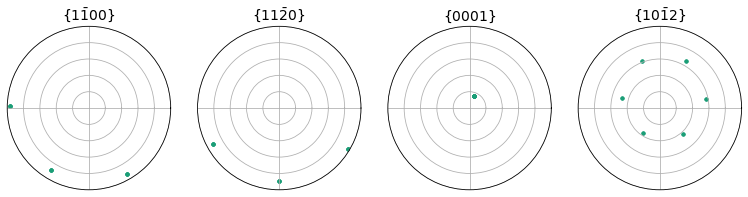

In [77]:

met_poles = projections.project_crystal_poles(poles, 
                                              rot_mat=apply_rot@r_met,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='hexagonal', 
                                               latt_params=latt_params_hcp,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes, 
                                               apply_sym=True,
                                              ret_poles=True)



met_poles_1124 = met_poles[1][-1]
proj_met_poles_1124 = met_poles[0][3]


# Plot pole figures
fig = plot_pole_fig_paper( met_poles[0], poles=poles, pole_lbl=pole_lbl,
                          lattice_sys=lattice_system, axes=axes, 
                        marker_size=10, grid=True)

plt.show(fig)

## Tetragonal  $\mathrm{ZrO}_2$

### BCT lattice parameters 

In [19]:
# -----Required parameters-----------------------------
lattice_system = 'tetragonal'
latt_params_tzro2 = [3.6055, 3.6055, 5.1797, 90.0, 90.0, 90.0]  #a, b, c, α, β, γ
#------------------------------------------------------

params_dict_tzro2 = {'a': latt_params_tzro2[0],
                     'b': latt_params_tzro2[1],
                     'c': latt_params_tzro2[2],
                     'α': latt_params_tzro2[3],
                     'β': latt_params_tzro2[4],
                     'γ': latt_params_tzro2[5]}
M_tet = lattice.crystal2ortho( **params_dict_tzro2, normed=False,
                                  degrees=True, align='cz')

tet_latt_vecs = lattice.crystal2ortho( **params_dict_tzro2, normed=False,
                                  degrees=True, align='cz').T

cell_e = np.eye(3)
cell_ortho_t = np.dot(M_tet.T, cell_e)
cell_rec_t = lattice.reciprocal_lattice_vecs(cell_ortho_t)

tet_sym_ops = symmetry.SYM_OPS['tetragonal']

### FCT lattice parameters

In [20]:
# -----Required parameters-----------------------------
latt_params_fctzro2 = [np.sqrt(2)*3.6055, np.sqrt(2)*3.6055,
                       5.1797, 90.0, 90.0, 90.0] #a, b, c, α, β, γ

#------------------------------------------------------

params_dict_fctzro2 = {'a': latt_params_fctzro2[0],
                       'b': latt_params_fctzro2[1],
                       'c': latt_params_fctzro2[2],
                       'α': latt_params_fctzro2[3],
                       'β': latt_params_fctzro2[4],
                       'γ': latt_params_fctzro2[5]}
M_fct = lattice.crystal2ortho('tetragonal', **params_dict_fctzro2, normed=False,
                                  degrees=True, align='cz')

fct_latt_vecs = lattice.crystal2ortho('tetragonal', **params_dict_fctzro2, normed=False,
                                  degrees=True, align='cz').T
cell_e = np.eye(3)
cell_ortho_fct = np.dot(M_fct.T, cell_e)
cell_rec_fct = lattice.reciprocal_lattice_vecs(cell_ortho_fct)

### Load experimental data

In [21]:
# USER INPUT: Input file path-------------------------------------------------
home_path = './data/'
file_path = 'EBSD_oxide_region_2.ctf'
# ----------------------------------------------------------------------------

tw = widgets.ToggleButtons(
    description='Technique:',
    options=['ASTAR', 'EBSD'],
)
display(tw)

ToggleButtons(description='Technique:', options=('ASTAR', 'EBSD'), value='ASTAR')

In [22]:
# Read data
header = fileutils.read_ctf_header(os.path.join(home_path, file_path), )
n_ph = header['no_phases']

data = pd.read_csv(os.path.join(home_path, file_path), sep='\t', header=13 + n_ph).values

XCells = header['XCells']
YCells = header['YCells']
num_pix = XCells * YCells

idx_rows = np.tile(np.arange(XCells), YCells)
idx_cols = np.repeat(np.arange(YCells), XCells)

phases = data[:,0].astype(int)
phases -= 1
euler_angles = data[:,5:8]
mad = data[:,8]
bc = data[:,9]
bs = data[:,10]

phase_map = phases.reshape((XCells,YCells), order = 'F')

eul_map = euler_angles.reshape((XCells,YCells, 3), order = 'F')
eul_map_norm = np.copy(eul_map)
eul_map_norm[:,:,0] /= 360.0
eul_map_norm[:,:,1] /= 180.0
eul_map_norm[:,:,2] = coordgeometry.wrap_angles(eul_map_norm[:,:,2], 0.0, 360.0)
eul_map_norm[:,:,2] /= 360.0

mad_map = mad.reshape((XCells,YCells), order = 'F')
bc_map = bc.reshape((XCells,YCells), order = 'F')
bs_map = bs.reshape((XCells,YCells), order = 'F')

# Map options based on technique
map_opt = ['phases','euler angles']
tech = tw.value # technique type
if tech == 'EBSD':
    map_opt.append('mean angular deviation')
    map_opt.append('band contrast')
else:
    map_opt.append('reliability factor')
    map_opt.append('intensity')

In [23]:
print('Total number of pixels: ', num_pix)
print(header['phases'][0]['name'], np.sum(phases == 0))
print(header['phases'][1]['name'], np.sum(phases == 1))
print(header['phases'][2]['name'], np.sum(phases == 2))
print('Non-indexed', np.sum(phases == -1))

Total number of pixels:  558700
Zirconia tetragonal 346
Zirc-alloy4 616
Zr02 monoclinic 14262
Non-indexed 543476


In [24]:
# CHOOSE PHASE
ph_opt = [x['name'] for x in header['phases']]
all_ph_ind = [index+1 for index, value in enumerate(ph_opt)]

style = {'description_width': 'initial'}
w = widgets.RadioButtons(
    description='Choose a phase',
    options=ph_opt,
    layout=ipywidgets.Layout(width='100%', height='80px'),
    style=style
)
display(w)

RadioButtons(description='Choose a phase', layout=Layout(height='80px', width='100%'), options=('Zirconia tetr…

In [25]:
# Phase index, name and lattice parameters
ph_ind = ph_opt.index(w.value)
ph_name = w.value
ph_params = header['phases'][ph_ind]['lattice_params']

# Create masks to be used for plotting the right data
mask_1d = phases != ph_ind
mask_2d = np.repeat(mask_1d[:,np.newaxis], 2, axis=1)
mask_3d = np.repeat(mask_1d[:,np.newaxis], 3, axis=1)

print('Chosen phase: ')
print(header['phases'][ph_ind])

Chosen phase: 
{'name': 'Zirconia tetragonal', 'lattice_params': [3.6055, 3.6055, 5.1797, 90.0, 90.0, 90.0]}


### Plot publication pole figures 

In [36]:
# USER INPUT: Pole figure options---------------------------------------------
lattice_system = 'tetragonal'
poles = np.array([[0,0,1],[1,1,-12]]).T

proj_type = 'equal_area'   # 'stereographic' or 'equal_area'
plot_contour = False        # True or False
axes = 'xyz'                # 'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'
# ----------------------------------------------------------------------------



C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:102: UserWarning:

FixedFormatter should only be used together with FixedLocator



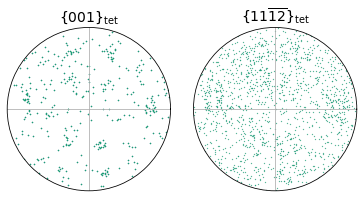

In [37]:
# thesis paper
# experimental
proj_poles, ppp = projections.project_crystal_poles(poles, 
                                               eulers=eulers_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                                apply_sym=True, ret_poles=True)

pole_lbl = [
            r'{$001$}$_{\mathrm{tet}}$',
            r'{$11\overline{12}$}$_{\mathrm{tet}}$',
            ]
fig = plot_pole_fig_paper(proj_poles=proj_poles, poles=poles,
                          lattice_sys=lattice_system, marker_size=0.01, pole_lbl=pole_lbl,

                         )
plt.show(fig)


## Monoclinic oxide $\mathrm{ZrO}_2$

### Lattice parameters

In [38]:
# -----Required parameters-----------------------------
lattice_system = 'monoclinic'
latt_params_mzro2 = [5.169, 5.232, 5.341, 90.0, 99.0, 90.0]  #a, b, c, α, β, γ

#------------------------------------------------------

params_dict_mzro2 = {
               'a': latt_params_mzro2[0],
               'b': latt_params_mzro2[1],
               'c': latt_params_mzro2[2],
               'α': latt_params_mzro2[3],
               'β': latt_params_mzro2[4],
               'γ': latt_params_mzro2[5]}
M_mon = lattice.crystal2ortho('monoclinic', **params_dict_mzro2, normed=True,
                                  degrees=True, align='cz')


mon_latt_vecs = lattice.crystal2ortho('monoclinic', **params_dict_mzro2, normed=False,
                                  degrees=True, align='cz').T
cell_e = np.eye(3)
cell_ortho_mon = np.dot(M_mon.T, cell_e)
cell_rec_mon = lattice.reciprocal_lattice_vecs(cell_ortho_mon)

### Load experimental data

In [39]:
# USER INPUT: Input file path-------------------------------------------------
home_path = './data/'
file_path = 'EBSD_oxide_region_2.ctf'

# ----------------------------------------------------------------------------

tw = widgets.ToggleButtons(
    description='Technique:',
    options=['ASTAR', 'EBSD'],
)
display(tw)


ToggleButtons(description='Technique:', options=('ASTAR', 'EBSD'), value='ASTAR')

In [41]:
# Read data
header = fileutils.read_ctf_header(os.path.join(home_path, file_path), )
n_ph = header['no_phases']

data = pd.read_csv(os.path.join(home_path, file_path), sep='\t', header=13 + n_ph).values

XCells = header['XCells']
YCells = header['YCells']
num_pix = XCells * YCells

idx_rows = np.tile(np.arange(XCells), YCells)
idx_cols = np.repeat(np.arange(YCells), XCells)

phases = data[:,0].astype(int)
phases -= 1
euler_angles = data[:,5:8]
mad = data[:,8]
bc = data[:,9]
bs = data[:,10]

phase_map = phases.reshape((XCells,YCells), order = 'F')

eul_map = euler_angles.reshape((XCells,YCells, 3), order = 'F')
eul_map_norm = np.copy(eul_map)
eul_map_norm[:,:,0] /= 360.0
eul_map_norm[:,:,1] /= 180.0
eul_map_norm[:,:,2] = coordgeometry.wrap_angles(eul_map_norm[:,:,2], 0.0, 360.0)
eul_map_norm[:,:,2] /= 360.0

mad_map = mad.reshape((XCells,YCells), order = 'F')
bc_map = bc.reshape((XCells,YCells), order = 'F')
bs_map = bs.reshape((XCells,YCells), order = 'F')

# Map options based on technique
map_opt = ['phases','euler angles']
tech = tw.value # technique type
if tech == 'EBSD':
    map_opt.append('mean angular deviation')
    map_opt.append('band contrast')
else:
    map_opt.append('reliability factor')
    map_opt.append('intensity')

In [42]:
print('Total number of pixels: ', num_pix)
print(header['phases'][0]['name'], np.sum(phases == 0))
print(header['phases'][1]['name'], np.sum(phases == 1))
print(header['phases'][2]['name'], np.sum(phases == 2))
print('Non-indexed', np.sum(phases == -1))

Total number of pixels:  558700
Zirconia tetragonal 346
Zirc-alloy4 616
Zr02 monoclinic 14262
Non-indexed 543476


### Plot experimental pole figures

In [43]:
ph_opt = [x['name'] for x in header['phases']]
all_ph_ind = [index+1 for index, value in enumerate(ph_opt)]

style = {'description_width': 'initial'}
w = widgets.RadioButtons(
    description='Choose a phase',
    options=ph_opt,
    layout=ipywidgets.Layout(width='100%', height='80px'),
    style=style,
    index=2
)
display(w)

RadioButtons(description='Choose a phase', index=2, layout=Layout(height='80px', width='100%'), options=('Zirc…

In [44]:
# Phase index, name and lattice parameters
ph_ind = ph_opt.index(w.value)
ph_name = w.value
ph_params = header['phases'][ph_ind]['lattice_params']

# Create masks to be used for plotting the right data
mask_1d = phases != ph_ind
mask_2d = np.repeat(mask_1d[:,np.newaxis], 2, axis=1)
mask_3d = np.repeat(mask_1d[:,np.newaxis], 3, axis=1)

print('Chosen phase: ')
print(header['phases'][ph_ind])

Chosen phase: 
{'name': 'Zr02 monoclinic', 'lattice_params': [5.1461, 5.2118, 5.313, 90.0, 99.22, 90.0]}


In [45]:
# USER INPUT: Pole figure options---------------------------------------------
lattice_system = 'monoclinic'
poles = np.array([[1,0,-1],[2,0,1],[1,-1,0],[1,1,0], [1,0,-6],[0,0,1],[1,1,1],[1,1,-1] ]).T
proj_type = 'equal_area'   # 'stereographic' or 'equal_area'
plot_contour = False        # True or False
axes = 'xyz'                # 'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'
# ----------------------------------------------------------------------------



c:\users\maria\onedrive - the university of manchester\code\matsci-tools\crystallographic-texture\crystex\plots.py:187: UserWarning:

FixedFormatter should only be used together with FixedLocator



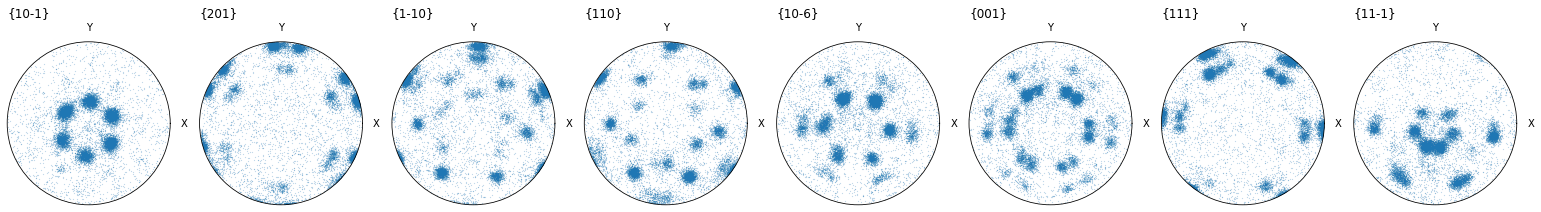

In [46]:
# code
eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0)
rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m, degrees=True))


# Find projections of poles
proj_poles = projections.project_crystal_poles(poles, 
                                               eulers=eulers_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=False)

    
# Plot pole figures
fig = plots.plot_pole_fig(proj_poles, poles=poles, 
                          lattice_sys=lattice_system, crys='poly', axes=axes, 
                          contour=False, bins = 20, marker_size=0.01)

plt.show(fig)


### Find major component

c:\users\maria\onedrive - the university of manchester\code\matsci-tools\crystallographic-texture\crystex\plots.py:187: UserWarning:

FixedFormatter should only be used together with FixedLocator



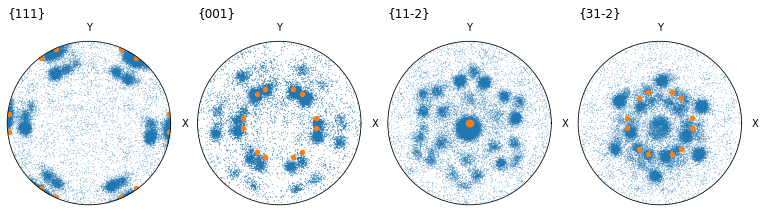

In [52]:
ax_m, ang_m = rotations.rotmat2axang(r_met, degrees=True)
r_ox = rotations.ax_ang2rot_mat(ax_m, 180, degrees=True)

# Monoclinic oxide texture direction
motex1 = np.array([[1,1,1]]).T
motex2 = np.array([[1,-1,1]]).T

# Convert to monoclinic to orthogonal
motex_ortho1 = np.dot(M_mon.T, motex1)
motex_ortho2 = np.dot(M_mon.T, motex2)

ang1 = 58
ang2 = 151

rn1 = rotation.axang2rotmat(np.array([0,0,1]), ang1, degrees=True)
rotmats1 = rotation.vecpair2rotmat(motex_ortho1, rn1 @ np.array([[1,0,0]]).T)[None]

r30 = rotation.axang2rotmat(np.array([0,0,1]), 30, degrees=True)
rn2 = rotation.axang2rotmat(np.array([0,0,1]), ang2, degrees=True)
rotmats2 = rotation.vecpair2rotmat(motex_ortho2, rn2 @ np.array([[1,0,0]]).T)[None]


poles = np.array([[1,1,1], [1,0,0],[0,1,0],[0,0,1], [1,0,-6],[-6,0,1], [1,1,-2],[3,1,-2]]).T
poles = np.array([[1,1,1],[0,0,1], [1,1,-2],[3,1,-2]]).T


poles2 = np.array([[1,1,-2],]).T

proj_poles = projections.project_crystal_poles(poles, 
#                                                eulers=eulers_m,
                                               rot_mat=rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,apply_sym=True)
proj_poles_th1 = projections.project_crystal_poles(poles=poles, 
                                                rot_mat=hcp_sym_ops @ rotmats1,    # eulers=eulers OR rot_mat=rot_mat
                                                crys='poly', 
                                                proj_type=proj_type,
                                                lattice_sys=lattice_system, 
                                                latt_params=latt_params_mzro2,
                                                pole_type=pole_type, 
                                                degrees=True,
                                                align=align,
                                                apply_sym=False)

fig = plots.plot_pole_fig(proj_poles=proj_poles, poles=poles, crys='poly',
                          lattice_sys=lattice_system, marker_size=0.01, contour=False,
                          bins=15, proj_poles_theory=proj_poles_th1)
plt.show(fig)


### Find minor component

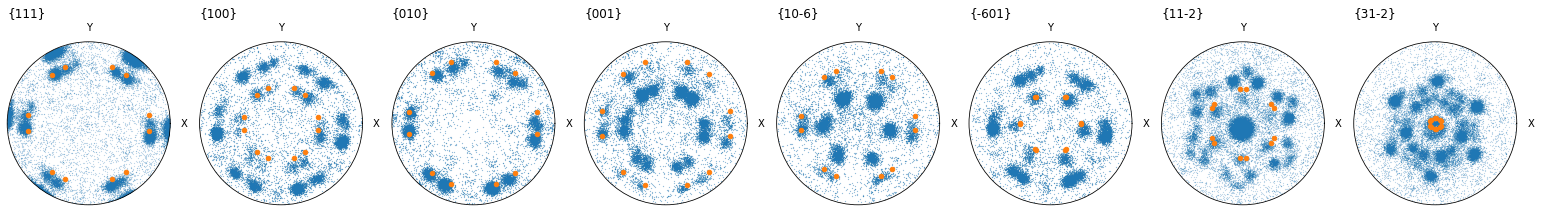

In [55]:
# 
# poles = np.array([[1,1,1], [1,0,0],[0,1,0],[0,0,1],[1,0,-3], [1,0,-6],[8, -2, -17]]).T
# Monoclinic oxide texture direction
motex1 = np.array([[1,1,1]]).T
motex2 = np.array([[1,-1,1]]).T

# Convert to monoclinic to orthogonal
motex_ortho1 = np.dot(M_mon.T, motex1)
motex_ortho2 = np.dot(M_mon.T, motex2)

ang = np.arange(60,180,1)
ang1 = 58
ang2 = 151

rn1 = rotation.axang2rotmat(np.array([0,0,1]), ang1, degrees=True)
rotmats1 = rotation.vecpair2rotmat(motex_ortho1, rn1 @ np.array([[1,0,0]]).T)[None]

r30 = rotation.axang2rotmat(np.array([0,0,1]), 30, degrees=True)
rn2 = rotation.axang2rotmat(np.array([0,0,1]), ang2, degrees=True)
rotmats2 = rotation.vecpair2rotmat(motex_ortho2, rn2 @ np.array([[1,0,0]]).T)[None]

poles = np.array([[1,1,1], [1,0,0],[0,1,0],[0,0,1], [1,0,-6],[-6,0,1],[1,1,-2], [3,1,-2]]).T
poles2 = np.array([[ 19,6, -12],[16,5, -10],[20,6, -13],[17,5, -11],[13, 4, -8],[14, 4,-9],[11, 3, -7]]).T

poles2= np.array([[3,1,-2]]).T

proj_poles = projections.project_crystal_poles(poles, 
                                               eulers=eulers_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                                apply_sym=True)
proj_poles_th2 = projections.project_crystal_poles(poles=poles, 
                                                rot_mat=  r30 @ hcp_sym_ops @ rotmats2,    # eulers=eulers OR rot_mat=rot_mat
                                                crys='poly', 
                                                proj_type=proj_type,
                                                lattice_sys=lattice_system, 
                                                latt_params=latt_params_mzro2,
                                                pole_type=pole_type, 
                                                degrees=True,
                                                align=align,
                                                apply_sym=False)

fig = plots.plot_pole_fig(proj_poles=proj_poles, poles=poles, crys='poly',
                          lattice_sys=lattice_system, marker_size=0.01, contour=False,
                          bins=5, proj_poles_theory=proj_poles_th2)
plt.show(fig)
# fig.savefig('minor.png', transparent=False, 
#           frameon=False, bbox_inches='tight', pad_inches=0)

### Publication figure

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:104: UserWarning:

FixedFormatter should only be used together with FixedLocator



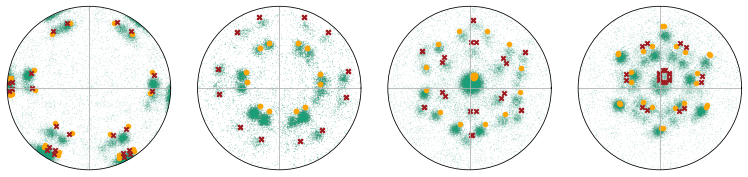

In [62]:
# code
poles = np.array([[1,1,1],[1,0,1], [0,0,1], [1,1,-2],[3,1,-2]]).T
poles = np.array([[1,1,1], [0,0,1], [1,1,-2],[3,1,-2]]).T

# experimental
proj_poles, ppp = projections.project_crystal_poles(poles, 
#                                                eulers=eulers_m,
                                               rot_mat=apply_rot@rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                                apply_sym=True, ret_poles=True)

# theoretical 1
proj_poles_th1 = projections.project_crystal_poles(poles=poles, 
                                                rot_mat=apply_rot@r_met @ hcp_sym_ops @ rotmats1,    # eulers=eulers OR rot_mat=rot_mat
                                                crys='poly', 
                                                proj_type=proj_type,
                                                lattice_sys=lattice_system, 
                                                latt_params=latt_params_mzro2,
                                                pole_type=pole_type, 
                                                degrees=True,
                                                align=align,
                                                apply_sym=True)

# theoretical 2
proj_poles_th2 = projections.project_crystal_poles(poles=poles, 
                                                rot_mat=  apply_rot@r_met @ r30 @ hcp_sym_ops @ rotmats2,    # eulers=eulers OR rot_mat=rot_mat
                                                crys='poly', 
                                                proj_type=proj_type,
                                                lattice_sys=lattice_system, 
                                                latt_params=latt_params_mzro2,
                                                pole_type=pole_type, 
                                                degrees=True,
                                                align=align,
                                                apply_sym=True)

pole_lbl = [r'$\{111\}_{\mathrm{mono}}$',
            r'$\{001\}_{\mathrm{mono}}$',
            r'$\{11\bar{2}\}_{\mathrm{mono}}$',
            r'$\{31\bar{2}\}_{\mathrm{mono}}$',
           ]

fig = plot_pole_fig_paper(proj_poles=proj_poles, poles=poles, 
                          lattice_sys=lattice_system, marker_size=0.001, 
                          proj_poles_theory=[proj_poles_th1,proj_poles_th2],
                          clrs=['orange', '#9e1b21', ]
                         )
plt.show(fig)


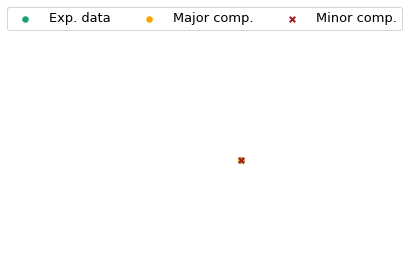

In [66]:
m = ['o', 'x']
cls=['orange', '#9e1b21', ]
    
ax = plt.subplot() 
ax.scatter(1,1, c='#1b9e77', marker='o',label='Exp. data',s=30,)
ax.scatter(1,1, c='orange', marker=m[0], label='Major comp.',s=30,)
ax.scatter(1,1, marker=m[1],label='Minor comp.', s=30, c='#9e1b21',linewidths=2)
ax.set_axis_off()  
ax.legend( fontsize=13, ncol=3, loc=5, bbox_to_anchor=(0., 1.1, 1., .102), borderaxespad=0.5)

